In [1]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# data = np.loadtxt('../data/original_data.csv', delimiter=' ')
df = pd.read_csv('../data/encoded_data.csv',sep=' ', names=['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode', 'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'label'])
df.head()

,issuercountry,txvariantcode,issuer_id,amount,currencycode,shoppercountry,interaction,verification,cvcresponse,creationdate_stamp,accountcode,mail_id,ip_id,card_id,label
0,18,10,465859.0,4370.0,3,26,1,2,1,1.444255e+09,0,32318,45370,1,0
1,68,4,438088.0,13850.0,2,134,1,1,0,1.438942e+09,1,1567,33933,2,0
2,18,12,552213.0,6595.0,3,26,1,1,1,1.437858e+09,0,64936,255836,3,0
3,18,10,492181.0,2895.0,3,26,1,1,1,1.443369e+09,0,95340,242162,4,0
4,55,9,493136.0,223900.0,0,69,1,1,0,1.442077e+09,3,250940,70404,5,0


## One-hot encoding

In [3]:
df = pd.get_dummies(df, columns=[
    'issuercountry',
    'txvariantcode',
    'currencycode',
    'shoppercountry',
    'verification',
    'cvcresponse',
    'accountcode'])

## Split data and label

In [4]:
X = np.asmatrix(df.drop(['label'], axis=1))
y = df['label']
print(X.shape)
print(y.shape)

(236698, 297)
(236698,)


## Normalization

In [62]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

## PCA

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)

(236698, 35)
[8.80706574e-02 6.81200342e-02 6.42310460e-02 6.41851578e-02
 6.40120317e-02 6.35637637e-02 6.31364527e-02 4.81718220e-02
 3.21169421e-02 3.21161753e-02 3.21157327e-02 3.21152715e-02
 3.21150584e-02 3.21133754e-02 3.21120413e-02 2.67981903e-02
 1.60585141e-02 1.60584699e-02 1.60581531e-02 1.60579773e-02
 1.60576182e-02 1.60574368e-02 1.60566000e-02 1.60562777e-02
 1.60558800e-02 1.60479954e-02 1.60470463e-02 1.60369390e-02
 1.60086075e-02 1.59647705e-02 9.95007781e-05 9.67562923e-05
 5.89019839e-05 1.74072338e-05 1.13955520e-05]


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)

(236698, 27)
[0.08807066 0.06812003 0.06423105 0.06418516 0.06401203 0.06356376
 0.06313645 0.04817182 0.03211694 0.03211618 0.03211573 0.03211527
 0.03211506 0.03211338 0.03211204 0.02679819 0.01605851 0.01605847
 0.01605815 0.01605798 0.01605762 0.01605744 0.0160566  0.01605628
 0.01605588 0.016048   0.01604705]


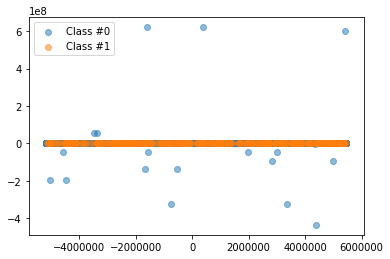

In [17]:
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label="Class #0",
                 alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label="Class #1",
                 alpha=0.5)
plt.legend()

## Classification: SMOTE + EEN -> 3-NN (10 cross-folded)

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

clf = make_pipeline(SMOTEENN(random_state=0), KNeighborsClassifier(n_neighbors=5))
y_score = cross_val_predict(clf, X_pca, y, cv=10, method='predict_proba')

In [8]:
from collections import Counter

# print confusion matrix
y_pred = (y_score[:,1] > 0.5).astype(int)
print(confusion_matrix(y,y_pred))
print(sorted(Counter(y_pred).items()))

[[232135   4218]
 [   287     58]]
[(0, 232422), (1, 4276)]


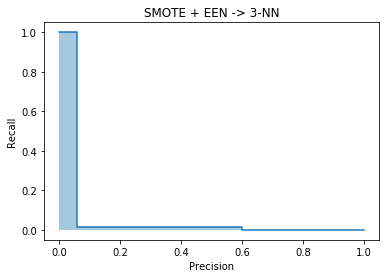

In [10]:
from sklearn.metrics import precision_recall_curve, auc

# calculate PR curve values
prec, rec, thresholds = precision_recall_curve(y, y_score[:,1])

# compute area under PR curve
area =  auc(prec, rec)

# fill area under curve
plt.fill_between(rec, prec, step="mid", alpha=0.4)

# plot PR curve
plt.step(rec, prec, where='mid', label='PR (area = {0:0.2f})'.format(area))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('SMOTE + EEN -> 3-NN')
plt.savefig(('pr_curve_white_box_%f' % np.random.rand()).replace('.',''), ext='png', pdi=150)

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y, y_pred))